# ResNet50 + LSTM

This model utilizes ResNet50, a pre-trained convolutional neural network, to extract high-dimensional image features. These features are passed to a Long Short-Term Memory (LSTM) network, which decodes the visual representation into meaningful captions.

The pipeline involves:

Feature extraction using ResNet50.
Sequential text generation using LSTM.

## Import Library

In [1]:
import numpy as np
import json
import os
import os.path
import pickle
from collections import Counter, defaultdict

from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data

from torchvision import transforms
from nltk.translate.bleu_score import corpus_bleu

import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Dataset & Preprocessing

To train this model, we use the MS-COCO dataset, which contains thousands of images paired with human-generated captions.

Image Preprocessing: Images are resized to a fixed size, normalized using pre-trained ResNet50 mean and standard deviation, and converted into feature vectors.

Text Preprocessing: Captions are tokenized into words, converted to numerical indices using a vocabulary, and padded to ensure consistent input sizes.

In [3]:
# Vocabulary

class Vocabulary(object):
    def __init__(
        self,
        vocab_threshold,
        vocab_file="/kaggle/input/resnet-lstm-result/vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file="/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json",
        vocab_from_file=False,
    ):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word

        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, idx in enumerate(ids):
            caption = str(coco.anns[idx]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [4]:
# Coco Dataset

class CoCoDataset(data.Dataset):
    def __init__(
        self,
        transform,
        mode,
        batch_size,
        vocab_threshold,
        vocab_file,
        start_word,
        end_word,
        unk_word,
        annotations_file,
        vocab_from_file,
        img_folder,
    ):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.img_folder = img_folder
        self.vocab = Vocabulary(
            vocab_threshold,
            vocab_file,
            start_word,
            end_word,
            unk_word,
            annotations_file,
            vocab_from_file,
        )
        if self.mode == "train":
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())

            tokenized_captions = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]["caption"]).lower()
                )
                for index in tqdm(np.arange(len(self.ids)))
            ]

            self.caption_lengths = [len(token) for token in tokenized_captions]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]

    def __getitem__(self, index):
        if self.mode == "train":
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]

            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = [self.vocab(self.vocab.start_word)]
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        else:
            path = self.paths[index]

            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            orig_image = np.array(pil_image)
            image = self.transform(pil_image)

            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [
                self.caption_lengths[i] == sel_length
                for i in np.arange(len(self.caption_lengths))
            ]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == "train":
            return len(self.ids)
        else:
            return len(self.paths)

In [5]:
# Get Loader

def get_loader(
    transform,
    mode="train",
    batch_size=1,
    vocab_threshold=None,
    vocab_file="/kaggle/input/resnet-lstm-result/vocab.pkl",
    start_word="<start>",
    end_word="<end>",
    unk_word="<unk>",
    vocab_from_file=True,
    num_workers=4,
    pin_memory = True,
    cocoapi_loc="/opt",
):

    if mode == "train":
        img_folder = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
        annotations_file = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

    elif mode == "test":
        img_folder = "/kaggle/input/test-data/test2017/test2017"
        annotations_file = "/kaggle/input/test-data/image_info_test2017.json"
    else:
        raise ValueError(f"Invalid mode: {mode}")

    dataset = CoCoDataset(
        transform=transform,
        mode=mode,
        batch_size=batch_size,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_word=start_word,
        end_word=end_word,
        unk_word=unk_word,
        annotations_file=annotations_file,
        vocab_from_file=vocab_from_file,
        img_folder=img_folder,
    )

    if mode == "train":
        indices = dataset.get_train_indices()

        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)

        data_loader = data.DataLoader(
            dataset=dataset,
            num_workers=num_workers,
            pin_memory=pin_memory,
            batch_sampler=data.sampler.BatchSampler(
                sampler=initial_sampler, batch_size=dataset.batch_size, drop_last=False
            ),
        )
    else:
        data_loader = data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    return data_loader

In [6]:
import json
import os
import nltk
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
from tqdm import tqdm

def val_get_loader(
    transform,
    mode="valid",
    batch_size=1,
    vocab_threshold=None,
    vocab_file="/kaggle/input/resnet-lstm-result/vocab.pkl",
    start_word="<start>",
    end_word="<end>",
    unk_word="<unk>",
    vocab_from_file=True,
    num_workers=0,
    cocoapi_loc="/opt",
):
    assert mode in ["train", "valid", "test"], "mode must be one of 'train' or 'test'."
    if not vocab_from_file:
        assert mode == "train"

    if mode == "train":
        if vocab_from_file:
            assert os.path.exists(vocab_file)
        img_folder = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
        annotations_file = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"
    elif mode == "test":
        assert batch_size == 1
        assert os.path.exists(vocab_file)
        assert vocab_from_file
        img_folder = "/kaggle/input/private-dataset/test2017"
        annotations_file = "/kaggle/input/private-dataset/image_info_test2017.json"
    elif mode == "valid":
        assert batch_size == 1
        assert os.path.exists(vocab_file)
        assert vocab_from_file
        img_folder = "/kaggle/input/coco-2017-dataset/coco2017/val2017"
        annotations_file = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json"
    else:
        raise ValueError(f"Invalid mode: {mode}")
    
    dataset = CoCoDataset(
        transform=transform,
        mode=mode,
        batch_size=batch_size,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_word=start_word,
        end_word=end_word,
        unk_word=unk_word,
        annotations_file=annotations_file,
        vocab_from_file=vocab_from_file,
        img_folder=img_folder,
    )

    if mode == "train":
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)

        data_loader = data.DataLoader(
            dataset=dataset,
            num_workers=num_workers,
            batch_sampler=data.sampler.BatchSampler(
                sampler=initial_sampler, batch_size=dataset.batch_size, drop_last=False
            ),
        )
    else:
        data_loader = data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    return data_loader


class CoCoDataset(data.Dataset):
    def __init__(
        self,
        transform,
        mode,
        batch_size,
        vocab_threshold,
        vocab_file,
        start_word,
        end_word,
        unk_word,
        annotations_file,
        vocab_from_file,
        img_folder,
    ):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(
            vocab_threshold,
            vocab_file,
            start_word,
            end_word,
            unk_word,
            annotations_file,
            vocab_from_file,
        )
        self.img_folder = img_folder
        if self.mode == "train":
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print("Obtaining caption lengths...")
            all_tokens = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]["caption"]).lower()
                )
                for index in tqdm(np.arange(len(self.ids)))
            ]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]

    def __getitem__(self, index):
        if self.mode == "train":
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]
            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()
            return image, caption

        elif self.mode == "valid":
            path = self.paths[index]
            image_id = int(path.split("/")[0].split(".")[0].split("_")[-1])
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(pil_image)
            return image_id, image
        else:
            path = self.paths[index]
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            orig_image = np.array(pil_image)
            image = self.transform(pil_image)
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [
                self.caption_lengths[i] == sel_length
                for i in np.arange(len(self.caption_lengths))
            ]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == "train":
            return len(self.ids)
        else:
            return len(self.paths)


In [7]:
# Convert back sentence

def clean_sentence(output, idx2word):
    sentence = ""
    for i in output:
        word = idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + " " + word
    return sentence

## ResNet + LSTM Architecture

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models


# Encoder: ResNet50
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


# Decoder: LSTM
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()

        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):

        cap_embedding = self.embed(
            captions[:, :-1]
        )


        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        lstm_out, self.hidden = self.lstm(
            embeddings
        )
        outputs = self.linear(lstm_out)

        return outputs

    def sample(self, inputs, states=None, max_len=20):

        res = []

        for i in range(max_len):
            lstm_out, states = self.lstm(
                inputs, states
            )
            outputs = self.linear(lstm_out.squeeze(dim=1))
            _, predicted_idx = outputs.max(dim=1)
            res.append(predicted_idx.item())

            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx)

            inputs = inputs.unsqueeze(1)

        return res

In [9]:
# Path to coco dataset

cocoapi_dir = '/kaggle/input/coco-2017-dataset/coco2017'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
# Setting hyperparameters

batch_size = 128
vocab_threshold = 5
vocab_from_file = True
embed_size = 256
hidden_size = 512
num_epochs = 3
save_every = 1
print_every = 500
log_file = "training_log.txt"

# Transform
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [12]:
# data_loader = get_loader(
#     transform=transform_train,
#     mode="train",
#     batch_size=batch_size,
#     vocab_threshold=vocab_threshold,
#     vocab_from_file=False,
#     cocoapi_loc=cocoapi_dir,
# )

In [13]:
# Set train loader

data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:54<00:00, 10797.87it/s]


In [14]:
vocab_size = len(data_loader.dataset.vocab)
print(vocab_size)

10330


## Training

The model is trained using the categorical cross-entropy loss to predict the next word in a caption sequence given the image features and preceding words. Optimization is done using the Adam optimizer, with teacher forcing used to improve learning.

In [15]:
# Setting up model

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

encoder.to(device)
decoder.to(device)

criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr=0.0001)

import math
total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


In [16]:
# Save path

# model_save_path = '/kaggle/working/output/save_path'
# os.makedirs(model_save_path, exist_ok=True)

In [17]:
# Load pre-trained weights before resuming training

# encoder.load_state_dict(torch.load("/kaggle/input/resnet-lstm-result/encoder-final.pkl"))
# decoder.load_state_dict(torch.load("/kaggle/input/resnet-lstm-result/decoder-final.pkl"))

In [18]:
# # Train Loop

# for epoch in range(1, num_epochs + 1):
#     for i_step in range(1, total_step + 1):

#         indices = data_loader.dataset.get_train_indices()

#         new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#         data_loader.batch_sampler.sampler = new_sampler

#         images, captions = next(iter(data_loader))

#         images = images.to(device)
#         captions = captions.to(device)

#         decoder.zero_grad()
#         encoder.zero_grad()

#         features = encoder(images)
#         outputs = decoder(features, captions)

#         loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

#         loss.backward()

#         optimizer.step()

#         stats = (
#             f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
#             f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
#         )

#         if i_step % print_every == 0:
#             print("\r" + stats)

#     if epoch % save_every == 0:
#         torch.save(
#             decoder.state_dict(), f"./decoder-{epoch}.pkl"
#         )
#         torch.save(
#             encoder.state_dict(), f"./encoder-{epoch}.pkl"
#         )


## Evaluation

To assess the performance of the image captioning models, we use the following metrics:

* BLEU (Bilingual Evaluation Understudy): Measures how many n-grams in the generated caption overlap with the reference captions.
    > BLEU-1: Measures unigram precision.
    > BLEU-2, BLEU-3, BLEU-4: Extend to bigrams, trigrams, and 4-grams, respectively.

* METEOR (Metric for Evaluation of Translation with Explicit ORdering): Considers precision, recall, and alignment by matching words and phrases. It accounts for synonyms and stemming, making it more semantically aware.

* ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation): Focuses on the longest common subsequence (LCS) between the generated and reference captions, capturing sentence-level structure.

In [19]:
# Validation set up

transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


val_data_loader = val_get_loader(
    transform=transform_test, mode="valid", cocoapi_loc=cocoapi_dir
)

# load trained encoder and decoder
encoder_file = "/kaggle/input/resnet-lstm-result/encoder.pkl"
decoder_file = "/kaggle/input/resnet-lstm-result/decoder.pkl"

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

encoder.eval()
decoder.eval()

<ipython-input-19-0af2788a8419>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_file))
<ipython-input-19-0af2788a8419>:31: Futur

DecoderRNN(
  (embed): Embedding(10330, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=10330, bias=True)
)

In [20]:
# Call all caption from val

pred_result = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder(img)
        features = features.unsqueeze(0).permute(1, 0, 2)
        output = decoder.sample(features)
    sentence = clean_sentence(output, val_data_loader.dataset.vocab.idx2word)
    pred_result[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [02:29<00:00, 33.38it/s]


In [21]:
print(output)

[0, 3, 615, 35, 25, 49, 9, 615, 1567, 12, 1]


In [22]:
# Validation result

with open(
    "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json", "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

In [23]:
list(valid_result.values())[:3]

[['a black honda motorcycle parked in front of a garage.',
  'a honda motorcycle parked in a grass driveway',
  'a black honda motorcycle with a dark burgundy seat.',
  'ma motorcycle parked on the gravel in front of a garage',
  'a motorcycle with its brake extended standing outside'],
 ['an office cubicle with four different types of computers.',
  'the home office space seems to be very cluttered.',
  'an office with desk computer and chair and laptop.',
  'office setting with a lot of computer screens.',
  'a desk and chair in an office cubicle.'],
 ['a small closed toilet in a cramped space.',
  'a tan toilet and sink combination in a small room.',
  'this is an advanced toilet with a sink and control panel.',
  'a close-up picture of a toilet with a fountain.',
  'off white toilet with a faucet and controls. ']]

In [24]:
list(pred_result.values())[:3]

[[' a store display of a store front with a clock .'],
 [' a man sitting on a bench next to a tree .'],
 [' a group of young men playing a game of soccer .']]

In [25]:
pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.7 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Uninstall the previous installed nltk library
!pip install -U nltk

# This upgraded nltkto version 3.5 in which meteor_score is there.
!pip install nltk==3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=9008c0c022670d8b5b3995496ce426eefa2d1a1ba8cd43a53cbc89cc3982f9fa
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
 

In [27]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

In [28]:
def calculate_rouge_l(predicted, references):
    def lcs_length(x, y):
        dp = [[0] * (len(y) + 1) for _ in range(len(x) + 1)]
        for i in range(1, len(x) + 1):
            for j in range(1, len(y) + 1):
                if x[i-1] == y[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[-1][-1]

    rouge_l_scores = []
    for ref in references:
        lcs = lcs_length(predicted, ref)
        precision = lcs / len(predicted) if len(predicted) > 0 else 0
        recall = lcs / len(ref) if len(ref) > 0 else 0
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0
        rouge_l_scores.append(f1)

    return max(rouge_l_scores)  # Use the best matching reference

In [33]:
def evaluate_metrics(pred_result, valid_result):
    references = []
    hypotheses = []

    for img_id in tqdm(pred_result.keys(), desc="Tokenizing captions"):
        if img_id in valid_result:
            tokenized_references = [word_tokenize(ref) for ref in valid_result[img_id]]
            tokenized_hypothesis = word_tokenize(pred_result[img_id][0])
            references.append(tokenized_references)
            hypotheses.append(tokenized_hypothesis)

    # Format data for Meteor and CIDEr
    meteor_references = {i: [' '.join(ref) for ref in references[i]] for i in range(len(references))}
    meteor_hypotheses = {i: [' '.join(hypotheses[i])] for i in range(len(hypotheses))}  # Wrap in a list

    # Calculate BLEU scores
    print("Calculating BLEU scores...")
    smoothing = SmoothingFunction().method1
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    # Calculate METEOR score
    print("Calculating METEOR score...")
    meteor_scorer = Meteor()
    meteor_score = meteor_scorer.compute_score(meteor_references, meteor_hypotheses)[0]

    # Calculate CIDEr score
    print("Calculating CIDEr score...")
    cider_scorer = Cider()
    cider_score = cider_scorer.compute_score(meteor_references, meteor_hypotheses)[0]

    # Calculate ROUGE-L score
    print("Calculating ROUGE-L score...")
    rouge_l_scores = []
    for pred, refs in zip(hypotheses, references):
        rouge_l_scores.append(calculate_rouge_l(pred, refs))
    rouge_l_score = np.mean(rouge_l_scores)

    results = {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor_score,
        "CIDEr": cider_score,
        "ROUGE-L": rouge_l_score,
    }

    return results


In [34]:
scores = evaluate_metrics(pred_result, valid_result)

print(scores)

Tokenizing captions: 100%|██████████| 5000/5000 [00:02<00:00, 1930.69it/s]


Calculating BLEU scores...
Calculating METEOR score...
Calculating CIDEr score...
Calculating ROUGE-L score...
{'BLEU-1': 0.6863203512573416, 'BLEU-2': 0.47656154015783836, 'BLEU-3': 0.3337512481022117, 'BLEU-4': 0.2305707055678305, 'METEOR': 0.22044761329732981, 'CIDEr': 0.7117179943752542, 'ROUGE-L': 0.5060922241896048}


## Get Prediction

In [36]:
# Get prediction

def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

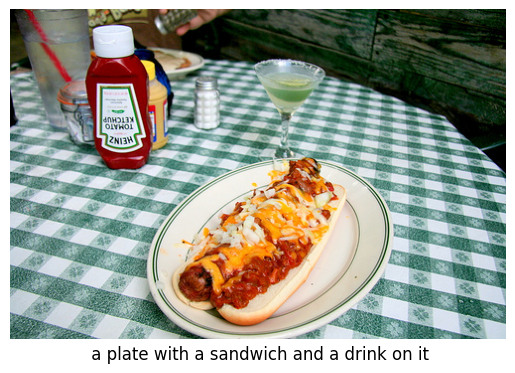

In [38]:
from PIL import Image
import torchvision.transforms as transforms

def load_vocab(vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    return vocab

def load_image(image_path, transform=None):
    """Load an image from file and apply transformations."""
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image).unsqueeze(0)
    return image

def get_prediction_new(idx2word, image_path, save=False, i=0):
    orig_image = Image.open(image_path).convert('RGB')
    image = load_image(image_path, transform_test).to(device)

    # Generate features and predict
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    # Display the image and prediction
    ax = plt.axes()
    # remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(orig_image)
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()


# Load vocab.pkl
vocab_path = "/kaggle/input/resnet-lstm-result/vocab.pkl" 
vocab = load_vocab(vocab_path)
idx2word = vocab.idx2word 

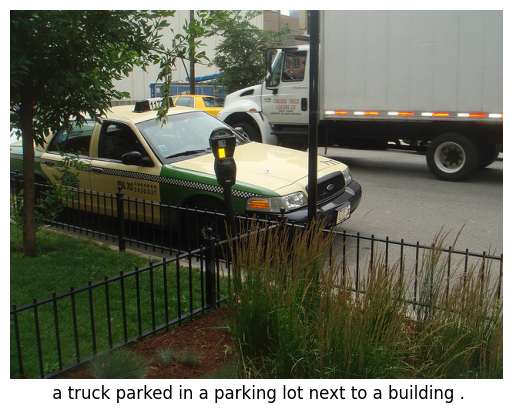

In [41]:
image_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000001.jpg"
get_prediction_new(idx2word, image_path)

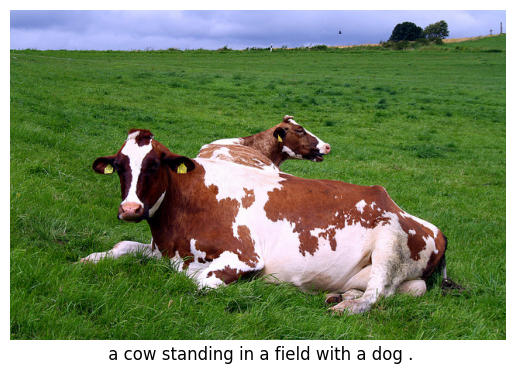

In [42]:
image_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000019.jpg"
get_prediction_new(idx2word, image_path)